## Import all packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from sklearn.metrics import silhouette_score, pairwise_distances, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

import bokeh
from bokeh.plotting import show as show_interactive
from bokeh.plotting import output_file, output_notebook
from bokeh.layouts import column, row
from bokeh.models import CustomJS, TextInput, LassoSelectTool, Select, MultiSelect, ColorBar, Legend, LegendItem
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn, Button, HTMLTemplateFormatter
from bokeh.events import SelectionGeometry
from bokeh.transform import linear_cmap, jitter
from matplotlib.pyplot import show as show_static
# from clustergrammer2 import net, Network, CGM2

import igraph as ig
import leidenalg as la

import scipy.stats as st
import scipy.spatial
import scipy.cluster.hierarchy

import glob
import json
import re
import copy

import requests
import bs4
import tqdm
import os

from Bio import SeqIO

import umap
import pymde

import torch

import networkx as nx

# bokeh.io.output_notebook()

In [2]:
full_filtered_df = pd.read_csv('../../new_raw_data/rna_seq_processed/kallisto.csv')
num_genes = full_filtered_df.shape[0]
num_genes

23880

In [3]:
max((full_filtered_df.iloc[:, 1:].to_numpy()).flatten())

2.4494897427831788

In [4]:
min((full_filtered_df.iloc[:, 1:].to_numpy()).flatten())

-2.428790564518942

In [5]:
full_filtered_df.head()

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min
0,TTHERM_000000042,-1.365347,-1.148579,-0.747968,0.326896,1.162457,1.223924,0.548616
1,TTHERM_000000045,1.624606,1.127653,-0.375801,-0.049446,-0.968655,-1.415563,0.057206
2,TTHERM_000000090,1.142246,-1.681917,-1.085635,0.091523,0.154576,1.283089,0.096118
3,TTHERM_00000010,1.990007,1.031465,-0.706626,-0.669459,-0.833015,-0.358390,-0.453982
4,TTHERM_00000020,-0.476728,-0.547781,1.301147,-1.215550,0.859255,-1.091681,1.171338


In [6]:
full_filtered_df.columns[1:]

Index(['000min', '030min', '060min', '090min', '120min', '150min', '180min'], dtype='object')

## Define functions

In [7]:
def compute_nns(data_df, nn, metric, random_state=42, n_jobs=-1, p_minkowski=1, distance_matrix=None):
    
    # if metric == 'clr':
    num_neighbors = NearestNeighbors(n_neighbors=nn-1, metric='precomputed', n_jobs=-1).fit(distance_matrix)
    nn_dists, nn_idxs = num_neighbors.kneighbors(return_distance=True)

    nn_dists_list = []
    nn_idxs_list = []

    # add the node itself to the nearest neighbors data 
    for idx in range(len(nn_dists)):
        nn_dists_list.append(np.flip(np.append(np.flip(nn_dists[idx]), 0)))
        nn_idxs_list.append(np.flip(np.append(np.flip(nn_idxs[idx]), idx)))

    return np.array(nn_idxs_list), np.array(nn_dists_list)

In [8]:
def get_geom_mean_expression(expression_df):
    """
    
    Function to take an expression dataframe from the microarrays and collapse it into the means of
    all replicate chips.
    """
    # C2 and S12 got removed during quality control
    x = [
        'Ll', 
        'Lm', 
        'Lh', 
        'S0', 
        'S3', 
        'S6', 
        'S9', 
        # 'S12', 
        'S15', 
        'S24', 
        'C0', 
        # 'C2', 
        'C4', 
        'C6', 
        'C8', 
        'C10', 
        'C12', 
        'C14', 
        'C16', 
        'C18']
    
    # cols = expression_df.columns[1:]
    # x = [c for c in x if c in cols]
    
    condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
    for c in list(expression_df.columns)[1:]:
        
        cond = c.split('_')[0]
        if cond in condition_expr_dict.keys():
            expr_list = condition_expr_dict.get(cond, [])

            # Need to avoid true zeros
            expr_list.append(expression_df[c].values)
            condition_expr_dict[cond] = expr_list
        
    condition_mean_dict = {c: (st.mstats.gmean(np.array(condition_expr_dict[c]) + 1, 0) - 1) for c in condition_expr_dict.keys() if c in x}
    
    mean_expr_df = pd.DataFrame(condition_mean_dict)
    mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
    cols = list(mean_expr_df.columns)
    reorder = cols[-1:] + cols[:-1]
    mean_expr_df = mean_expr_df[reorder]
    
    return mean_expr_df

def normalizer(array):
    """
    Normalizes the values of an array to range from zero to one
    """
    
    a = np.array(array)
    
    normalized = (array - np.min(array)) / (np.max(array) - np.min(array))
    
    return normalized

def normalize_expression_per_gene(expression_df):
    """
    Function to normalize all gene expression to range from zero to one.
    """
    if 'TTHERM_ID' in expression_df.columns:
        ttids = expression_df['TTHERM_ID'].values
        data = expression_df[list(expression_df.columns)[1:]]
        
        norm_expression_df = data.apply(lambda row: normalizer(row), axis=1)
        norm_expression_df['TTHERM_ID'] = ttids
        
        columns = norm_expression_df.columns.tolist()
        
        rearrangment = columns[-1:] + columns[:-1]
        
        norm_expression_df = norm_expression_df[rearrangment]
        
    else:
        norm_expression_df = expression_df.apply(lambda row: normalizer(row), axis=1)
    
    return norm_expression_df
    


def run_leiden(df, n_components=2, n_neighbors=3, random_state=42, metric='manhattan', return_dists=True):
    """
    Function to compute the simplicial sets for coexpression using UMAP and to then apply
    the Leiden algorithm to cluster the resulting graph.
    
    Parameters:
    -----------
    df : pandas dataframe
        the expression data
    n_components : int (default 2)
        the number of dimensions onto which the data should be projected
    n_neighbors : int (default 15)
        a parameter for the UMAP algorithm. I think it has to do with balancing
        local vs. global topology in the data
    random_state : float (default 42)
        Constraining this parameter makes the output reproducible
    metric : str (default "euclidean")
        The distance function
    return_dists : Bool (default True)
        Whether the function should return the computed distances
        
    Returns:
    --------
    leiden_modules : np array
        An array of ints, each corresponding to the module (or cluster) to which a gene belongs,
        listed in order of the input dataframe
    """
    
    data = df[list(df.columns)[1:]].values
    
#     mapper = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors).fit(data)
    
    result, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(data, n_neighbors, random_state, metric, return_dists=return_dists)
    
    sources, targets = result.nonzero()
    edge_list = zip(sources, targets)
    weights = result.data
    
    g = ig.Graph(edges=edge_list, edge_attrs={'weight': weights})
    
def run_leiden(df, n_components=2, n_neighbors=3, random_state=42, metric='manhattan', return_dists=True):
    """
    Function to compute the simplicial sets for coexpression using UMAP and to then apply
    the Leiden algorithm to cluster the resulting graph.
    
    Parameters:
    -----------
    df : pandas dataframe
        the expression data
    n_components : int (default 2)
        the number of dimensions onto which the data should be projected
    n_neighbors : int (default 15)
        a parameter for the UMAP algorithm. I think it has to do with balancing
        local vs. global topology in the data
    random_state : float (default 42)
        Constraining this parameter makes the output reproducible
    metric : str (default "euclidean")
        The distance function
    return_dists : Bool (default True)
        Whether the function should return the computed distances
        
    Returns:
    --------
    leiden_modules : np array
        An array of ints, each corresponding to the module (or cluster) to which a gene belongs,
        listed in ortder of the input dataframe
    """
    
    data = df[list(df.columns)[1:]].values
    
#     mapper = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors).fit(data)
    
    result, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(data, n_neighbors, random_state, metric, return_dists=return_dists)
    
    sources, targets = result.nonzero()
    edge_list = zip(sources, targets)
    weights = result.data
    
    g = ig.Graph(edges=edge_list, edge_attrs={'weight': weights})
    
def run_leiden(df, n_components=2, n_neighbors=3, random_state=42, metric='manhattan', return_dists=True):
    """
    Function to compute the simplicial sets for coexpression using UMAP and to then apply
    the Leiden algorithm to cluster the resulting graph.
    
    Parameters:
    -----------
    df : pandas dataframe
        the expression data
    n_components : int (default 2)
        the number of dimensions onto which the data should be projected
    n_neighbors : int (default 15)
        a parameter for the UMAP algorithm. I think it has to do with balancing
        local vs. global topology in the data
    random_state : float (default 42)
        Constraining this parameter makes the output reproducible
    metric : str (default "euclidean")
        The distance function
    return_dists : Bool (default True)
        Whether the function should return the computed distances
        
    Returns:
    --------
    leiden_modules : np array
        An array of ints, each corresponding to the module (or cluster) to which a gene belongs,
        listed in ortder of the input dataframe
    """
    
    data = df[list(df.columns)[1:]].values
    
#     mapper = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors).fit(data)
    
    result, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(data, n_neighbors, random_state, metric, return_dists=return_dists)
    
    sources, targets = result.nonzero()
    edge_list = zip(sources, targets)
    weights = result.data
    
    g = ig.Graph(edges=edge_list, edge_attrs={'weight': weights})
    
def run_leiden(df, n_components=2, n_neighbors=3, random_state=42, metric='manhattan', return_dists=True):
    """
    Function to compute the simplicial sets for coexpression using UMAP and to then apply
    the Leiden algorithm to cluster the resulting graph.
    
    Parameters:
    -----------
    df : pandas dataframe
        the expression data
    n_components : int (default 2)
        the number of dimensions onto which the data should be projected
    n_neighbors : int (default 15)
        a parameter for the UMAP algorithm. I think it has to do with balancing
        local vs. global topology in the data
    random_state : float (default 42)
        Constraining this parameter makes the output reproducible
    metric : str (default "euclidean")
        The distance function
    return_dists : Bool (default True)
        Whether the function should return the computed distances
        
    Returns:
    --------
    leiden_modules : np array
        An array of ints, each corresponding to the module (or cluster) to which a gene belongs,
        listed in ortder of the input dataframe
    """
    
    data = df[list(df.columns)[1:]].values
    
#     mapper = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors).fit(data)
    
    result, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(data, n_neighbors, random_state, metric, return_dists=return_dists)
    
    sources, targets = result.nonzero()
    edge_list = zip(sources, targets)
    weights = result.data
    
    g = ig.Graph(edges=edge_list, edge_attrs={'weight': weights})
    
def run_leiden(df, n_components=2, n_neighbors=3, random_state=42, metric='manhattan', return_dists=True):
    """
    Function to compute the simplicial sets for coexpression using UMAP and to then apply
    the Leiden algorithm to cluster the resulting graph.
    
    Parameters:
    -----------
    df : pandas dataframe
        the expression data
    n_components : int (default 2)
        the number of dimensions onto which the data should be projected
    n_neighbors : int (default 15)
        a parameter for the UMAP algorithm. I think it has to do with balancing
        local vs. global topology in the data
    random_state : float (default 42)
        Constraining this parameter makes the output reproducible
    metric : str (default "euclidean")
        The distance function
    return_dists : Bool (default True)
        Whether the function should return the computed distances
        
    Returns:
    --------
    leiden_modules : np array
        An array of ints, each corresponding to the module (or cluster) to which a gene belongs,
        listed in ortder of the input dataframe
    """
    
    data = df[list(df.columns)[1:]].values
    
#     mapper = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors).fit(data)
    
    result, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(data, n_neighbors, random_state, metric, return_dists=return_dists)
    
    sources, targets = result.nonzero()
    edge_list = zip(sources, targets)
    weights = result.data
    
    g = ig.Graph(edges=edge_list, edge_attrs={'weight': weights})
    
    
def run_leiden(df, n_components=2, n_neighbors=3, random_state=42, metric='manhattan', leiden_type='modularity', la_res_param=1.0, return_dists=True):
    """
    Function to compute the simplicial sets for coexpression using UMAP and to then apply
    the Leiden algorithm to cluster the resulting graph.
    
    Parameters:
    -----------
    df : pandas dataframe
        the expression data
    n_components : int (default 2)
        the number of dimensions onto which the data should be projected
    n_neighbors : int (default 15)
        a parameter for the UMAP algorithm. I think it has to do with balancing
        local vs. global topology in the data
    random_state : float (default 42)
        Constraining this parameter makes the output reproducible
    metric : str (default "euclidean")
        The distance function
    return_dists : Bool (default True)
        Whether the function should return the computed distances
        
    Returns:
    --------
    leiden_modules : np array
        An array of ints, each corresponding to the module (or cluster) to which a gene belongs,
        listed in ortder of the input dataframe
    """
    
    data = df[list(df.columns)[1:]].values

    labels_idxs = list(range(data.shape[0]))  

#     mapper = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors).fit(data)
    
    manhattan_distance_matrix = pairwise_distances(data, metric='manhattan', n_jobs=-1)
    # nn = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed', n_jobs=-1).fit(manhattan_distance_matrix)
    # nn_dists, nn_idxs = nn.kneighbors(return_distance=True)

    nn_idxs, nn_dists = compute_nns(data, n_neighbors, metric, random_state, distance_matrix=manhattan_distance_matrix)
    
    result, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(data, n_neighbors, random_state, metric, knn_indices=nn_idxs, knn_dists=nn_dists, return_dists=return_dists)
    # result, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(data, n_neighbors, random_state, metric, return_dists=return_dists)


    
    sources, targets = result.nonzero()
    edge_list = zip(sources, targets)
    weights = result.data
    
    g = ig.Graph(edges=edge_list, edge_attrs={'weight': weights})
    nx_g = nx.Graph(g.get_edgelist())
    
    if leiden_type == 'modularity':
        partition = la.find_partition(g, la.ModularityVertexPartition, seed=random_state, weights='weight')
    elif leiden_type == 'cpm':
        partition = la.find_partition(g, la.CPMVertexPartition, resolution_parameter = la_res_param, seed=random_state, weights='weight')
    else:
        raise ValueError('Invalid value for leiden_type parameter')
    leiden_modules = np.array(partition.membership)

    communities = {}

    for idx, membership in enumerate(leiden_modules):
        if membership not in communities:
            communities[membership] = []
        communities[membership].append(labels_idxs[idx])

    sscore = silhouette_score(manhattan_distance_matrix, leiden_modules, metric='precomputed')
    modularity = nx.community.quality.modularity(nx_g, communities.values(), weight='weight')
    
    return leiden_modules, dists, sscore, modularity


def build_leiden_label_df(data_df, phases, random_state=42, n_neighbors=3, metric='manhattan', leiden_type='modularity', la_res_param=1.0, lldf=None):
    """
    Function to build a dataframe of genes labeled according to their UMAP/Leiden modules
    
    Parameters:
    -----------
    data_df : pandas DataFrame
        The expression data
    phases : str ('full', 'veg', or 'sex')
        The physiological phases for which expression data is being provided
    lldf : pandas DataFrame (default None)
        Another leiden label df (lldf) to which to add a column
        
    Returns:
    --------
    lldf : pandas DataFrame
        Leiden Label DataFrame. Gene IDs and their corresponding UMAP/Leiden module
        computed for a specific physiological regime (full set (full), vegetative only
        (veg), or sexual only (sex))
    """
    
    if type(lldf) == type(None):
        lldf = pd.DataFrame.from_dict({'TTHERM_ID': []})
    
    leiden_modules, dists, sscore, modularity = run_leiden(data_df, random_state=random_state, n_neighbors=n_neighbors, metric=metric, leiden_type=leiden_type, la_res_param=la_res_param)
    lldf['TTHERM_ID'] = data_df['TTHERM_ID'].values
    
    lldf[f'leiden_label_{phases}'] = leiden_modules
    
    return lldf, dists, sscore, modularity


# The two functions below are taken and adapted from the UMAP package
def _get_umap_embedding(umap_object):
    if hasattr(umap_object, "embedding_"):
        return umap_object.embedding_
    elif hasattr(umap_object, "embedding"):
        return umap_object.embedding
    else:
        raise ValueError("Could not find embedding attribute of umap_object")
        
def plot_enrichment(enrich_column_data_source):
    
    # pdb.set_trace()
    
    # y_range = FactorRange(factors=[str(y) for y in enrich_df['module'].unique()])
    
    # grouped = enrich_df.groupby('module')
    
    hover = [
        ('module', '@module'),
        ('term', '@term'),
        ('info', '@info'),
        ('fold-change', '@fold_change'),
        ('bonferroni', '@bonferroni')
    ]
    
    p = bokeh.plotting.figure(
        height=1000,
        width=400,
        # y_range=y_range,
        title='Functional term enrichment in modules',
        x_axis_label='fold-change',
        y_axis_label='module',
        x_axis_type='log',
        tooltips=hover,
        # background_fill_color='black'
    )
    
    # cds = bokeh.models.ColumnDataSource(enrich_df)
    # print(enrich_df.head())
    
    p.circle(y=jitter('module', width=0.4), x='fold_change', source=enrich_column_data_source, alpha=0.3, size=7, color='color', line_color='black')
    # p.xaxis.major_label_orientation = 45
    p.ygrid.minor_grid_line_color = 'navy'
    p.ygrid.minor_grid_line_alpha = 0.1
    # p.xgrid.band_fill_alpha = 0.1
    # p.xgrid.band_fill_color = "navy"
    ticker = []
    for m in enrich_column_data_source.data['module']:
        if m not in ticker:
            ticker.append(m)
    p.yaxis.ticker = ticker
    p.y_range.flipped = True
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'
    p.xaxis.axis_label_text_font_size = '12pt'
    
    return p

def heatmap(column_data_source, ls_color_palette, r_low, r_high, x_axis_factors, y_axis_factors, s_z="normalized_expression", index_name='TTHERM_ID', col_name='phase'):
    # adapted from https://gitlab.com/biotransistor/bokehheat/-/blob/master/bokehheat/heat.py
    """
    input:
        df_matrx: a dataframe in same xy orientation as the final heatmap.
          the index should cary the y axis label.
          the column should cary the x axis label.
          the matrix as such should only cary the z axis values.

        ls_color_palette: a list color strings to specify the color spectrum.
            this variable is compatible with the ordinary bokeh palettes:
            https://bokeh.pydata.org/en/latest/docs/reference/palettes.html

        r_low: quantitative minimum value. the dataset can contain lower values,
            but for color labeling they will be mapped to this minimum value.
            e.g.: -8.

        r_high: quantitative maximum value. the dataset can contain lower values,
            but for color labeling they will be mapped to this maximum value.
            e.g.: 8.

        s_z: string. label that specifies what the values in the matrix actually
            are. e.g.: 'gene expression [log2]'

    output:
        p: bokeh plot object.

    description:
        this function will return a bokeh based interactive heatmap plot.
        the color are representing the z value.
    """
    # index as string
#     df_matrix.index = df_matrix.index.astype(str)
#     df_matrix.columns = df_matrix.columns.astype(str)

#     # handle y and x axis name
#     if (df_matrix.index.name == None):
#         df_matrix.index.name = "y_axis"
#     if (df_matrix.columns.name == None):
#         df_matrix.columns.name = "x_axis"
    # pdb.set_trace()
    s_y = index_name
    
    # df_matrix.columns.name = 'phase'
    s_x = col_name
    
    
    # print(df_matrix.head())
    
    # melt dataframe
    # df_tidy = df_matrix.reset_index().melt(
    #     id_vars=[df_matrix.index.name],
    #     value_name=s_z
    # )
    # print(df_tidy.head())
    # color declaration
    d_zcolormapper = linear_cmap(
        field_name=s_z,
        palette=ls_color_palette,
        low=r_low,
        high=r_high
    )
    # tooltip declaration
    lt_tooltip = [
        (s_y, f"@{s_y}"),
        (s_x, f"@{s_x}"),
        (s_z, f"@{s_z}"),
        ('module', f'@module')
    ]
    # generate figure
    o_colorbar = ColorBar(color_mapper=d_zcolormapper['transform'])
    p = bokeh.plotting.figure(
        y_range=y_axis_factors,
        x_range=x_axis_factors,
        width=400,
        height=1000,
        tools = "box_zoom,hover,pan,reset,wheel_zoom,save",  # have to be set hardcoded
        active_drag = "box_zoom",  # have to be set hardcoded
        tooltips=lt_tooltip,
        title=s_z,
        toolbar_location='right',
        
    )
    
    p.rect(
        source=column_data_source,
        x=s_x,
        y=s_y,
        color=d_zcolormapper,
        width=1,
        height=1,
        fill_alpha='fill_alpha',
        line_alpha='line_alpha',
        # line_color='white',
        nonselection_fill_alpha=0.01,
        nonselection_line_alpha=0.01,
        # nonselection_line_color="white"
    )
    p.add_layout(o_colorbar, place='left')
    # p.yaxis.major_label_orientation = "horizontal"
    p.xaxis.major_label_orientation = 45
    # p.yaxis.major_label_text_font_size = '0pt'
    p.yaxis.visible = False
    p.xaxis.major_label_text_font_size = '12pt'

    # out
    return(p)
        
def interactive(
    embedding_df,
    x,
    # mean_expression_df,
    title=None,
    labels=None,
    values=None,
    hover_data=None,
    theme=None,
    cmap="Blues",
    color_key=None,
    color_key_cmap="Spectral",
    background="white",
#     width=800,
#     height=800,
    point_size=None,
    radius=None, # My contribution
#     subset_points=None,
    interactive_text_search=False,
    interactive_text_search_columns=None,
    interactive_text_search_alpha_contrast=0.999,
    alpha=None,
    normalized=True
):
    """Create an interactive bokeh plot of a UMAP embedding.
    While static plots are useful, sometimes a plot that
    supports interactive zooming, and hover tooltips for
    individual points is much more desireable. This function
    provides a simple interface for creating such plots. The
    result is a bokeh plot that will be displayed in a notebook.
    Note that more complex tooltips etc. will require custom
    code -- this is merely meant to provide fast and easy
    access to interactive plotting.
    Parameters
    ----------
    embedding_df: pandas DataFrame
        A expression dataframe with columns x and y, which are the
        2D embedding of a model (e.g., UMAP or pyMDE) on the expression data, and all the
        annotations, geometric means of expression, etc.
    x: list
        The categories for the x-axes of the heatmap and expression profiles
    labels: array, shape (n_samples,) (optional, default None)
        An array of labels (assumed integer or categorical),
        one for each data sample.
        This will be used for coloring the points in
        the plot according to their label. Note that
        this option is mutually exclusive to the ``values``
        option.
    values: array, shape (n_samples,) (optional, default None)
        An array of values (assumed float or continuous),
        one for each sample.
        This will be used for coloring the points in
        the plot according to a colorscale associated
        to the total range of values. Note that this
        option is mutually exclusive to the ``labels``
        option.
    hover_data: DataFrame, shape (n_samples, n_tooltip_features)
    (optional, default None)
        A dataframe of tooltip data. Each column of the dataframe
        should be a Series of length ``n_samples`` providing a value
        for each data point. Column names will be used for
        identifying information within the tooltip.
    theme: string (optional, default None)
        A color theme to use for plotting. A small set of
        predefined themes are provided which have relatively
        good aesthetics. Available themes are:
           * 'blue'
           * 'red'
           * 'green'
           * 'inferno'
           * 'fire'
           * 'viridis'
           * 'darkblue'
           * 'darkred'
           * 'darkgreen'
    cmap: string (optional, default 'Blues')
        The name of a matplotlib colormap to use for coloring
        or shading points. If no labels or values are passed
        this will be used for shading points according to
        density (largely only of relevance for very large
        datasets). If values are passed this will be used for
        shading according the value. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.
    color_key: dict or array, shape (n_categories) (optional, default None)
        A way to assign colors to categoricals. This can either be
        an explicit dict mapping labels to colors (as strings of form
        '#RRGGBB'), or an array like object providing one color for
        each distinct category being provided in ``labels``. Either
        way this mapping will be used to color points according to
        the label. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.
    color_key_cmap: string (optional, default 'Spectral')
        The name of a matplotlib colormap to use for categorical coloring.
        If an explicit ``color_key`` is not given a color mapping for
        categories can be generated from the label list and selecting
        a matching list of colors from the given colormap. Note
        that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.
    background: string (optional, default 'white')
        The color of the background. Usually this will be either
        'white' or 'black', but any color name will work. Ideally
        one wants to match this appropriately to the colors being
        used for points etc. This is one of the things that themes
        handle for you. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.
    width: int (optional, default 800)
        The desired width of the plot in pixels.
    height: int (optional, default 800)
        The desired height of the plot in pixels
    point_size: int (optional, default None)
        The size of each point marker
    radius: int (optional, default None)
        The radius of each point marker (adjusts the point size while zooming)
    subset_points: array, shape (n_samples,) (optional, default None)
        A way to select a subset of points based on an array of boolean
        values.
    interactive_text_search: bool (optional, default False)
        Whether to include a text search widget above the interactive plot
    interactive_text_search_columns: list (optional, default None)
        Columns of data source to search. Searches labels and hover_data by default.
    interactive_text_search_alpha_contrast: float (optional, default 0.95)
        Alpha value for points matching text search. Alpha value for points
        not matching text search will be 1 - interactive_text_search_alpha_contrast
    alpha: float (optional, default: None)
        The alpha blending value, between 0 (transparent) and 1 (opaque).
    Returns
    -------
    """
    if theme is not None:
        cmap = _themes[theme]["cmap"]
        color_key_cmap = _themes[theme]["color_key_cmap"]
        background = _themes[theme]["background"]

    if labels is not None and values is not None:
        raise ValueError(
            "Conflicting options; only one of labels or values should be set"
        )
        
    if alpha is not None:
        if not 0.0 <= alpha <= 1.0:
            raise ValueError("Alpha must be between 0 and 1 inclusive")

    if point_size is None and radius is None:
        point_size = 100.0 / np.sqrt(points.shape[0])
        
    data = embedding_df
    # data = data.set_index('TTHERM_ID')
    # pdb.set_trace()
    if radius is not None:
        data['radius'] = radius

    if labels is not None:
        data["label"] = labels

        if color_key is None:
            unique_labels = np.unique(labels)
            num_labels = unique_labels.shape[0]
            color_key = _to_hex(
                plt.get_cmap(color_key_cmap)(np.linspace(0, 1, num_labels))
            )

        if isinstance(color_key, dict):
            data["color"] = pd.Series(labels).map(color_key)
        else:
            # print('here')
            unique_labels = np.unique(labels)
            if len(color_key) < unique_labels.shape[0]:
                # raise ValueError(
                #     "Color key must have enough colors for the number of labels"
                # )
                
                print('Color key has fewer colors than labels. Making all white')
                data['color'] = ['white']*len(labels)
            else:

                new_color_key = {k: color_key[i] for i, k in enumerate(unique_labels)}
                data["color"] = pd.Series(labels).map(new_color_key)

        colors = "color"

    elif values is not None:
        data["value"] = values
        palette = _to_hex(plt.get_cmap(cmap)(np.linspace(0, 1, 256)))
        colors = btr.linear_cmap(
            "value", palette, low=np.min(values), high=np.max(values)
        )

    else:
        colors = matplotlib.colors.rgb2hex(plt.get_cmap(cmap)(0.5))

    # print(data['color'].unique())
    # print(colors)

    if hover_data is not None:
        tooltip_dict = {}
        for col_name in hover_data:
            data[col_name] = hover_data[col_name]
            tooltip_dict[col_name] = "@{" + col_name + "}"
        tooltips = list(tooltip_dict.items())
    else:
        tooltips = None

    if alpha is not None:
        data["alpha"] = alpha
    else:
        alpha = 1
        data["alpha"] = alpha

    data_source = bokeh.plotting.ColumnDataSource(data)
    data_source.data['module'] = hover_data['module']
    data_source.data['ID'] = hover_data['ID']
    data_source.data['radius'] = np.ones_like(hover_data['ID']) * radius
    data_source.data['alpha'] = np.ones_like(hover_data['ID']) * alpha
    
    # print(data_source.data['ID'][:5])

    plot = bokeh.plotting.figure(
        width=800,
        height=500,
        tooltips=tooltips,
        tools="tap,box_select,pan,wheel_zoom,box_zoom,reset,save",
        background_fill_color=background,
        title=title
#             x_range=(np.floor(min(points[:,0])), np.ceil(max(points[:,0]))), # Get axes
#             y_range=(np.floor(min(points[:,1])), np.ceil(max(points[:,1])))
    )

    if point_size is not None:

        plot.circle(
            x="x",
            y="y",
            source=data_source,
            color=colors,
            size=point_size,
            alpha="alpha",
            line_color='black'
        )

    elif radius is not None:
        plot.circle(
            x="x",
            y="y",
            source=data_source,
            color=colors,
            radius=radius,
            alpha="alpha",
            line_color='black'
        )

    plot.grid.visible = False
    plot.axis.visible = False

    
    x_heatmap_profile = x
    
    # ['Ll', 
    #      'Lm', 
    #      'Lh', 
    #      'S0', 
    #      'S3', 
    #      'S6', 
    #      'S9', 
    #      # 'S12', 
    #      'S15', 
    #      'S24', 
    #      'C0', 
    #      # 'C2', 
    #      'C4', 
    #      'C6', 
    #      'C8', 
    #      'C10', 
    #      'C12', 
    #      'C14', 
    #      'C16', 
    #      'C18']
    
    if normalized:
        hm_min = 0
        hm_max = 1
        
    else:
        hm_min = 2
        hm_max = 16
    
    # For companion heatmap plot
    ttherm_ids = embedding_df['TTHERM_ID'].values
    hm_df = embedding_df[['TTHERM_ID'] + x_heatmap_profile]
    hm_df['module'] = hover_data['module'].values
    hm_df_tidy = hm_df.melt(id_vars=['TTHERM_ID', 'module'], var_name='phase', value_name='normalized_expression')
    hm_cds = bokeh.plotting.ColumnDataSource(hm_df_tidy)
    hm_cds.data['fill_alpha'] = [0.7]*len(hm_df_tidy)
    hm_cds.data['line_alpha'] = [0.7]*len(hm_df_tidy)
    # hm_cds.data['y_axis'] = ttherm_ids
    
    hm = heatmap(hm_cds, bokeh.palettes.Inferno256, hm_min, hm_max, x_heatmap_profile, ttherm_ids)
    
    

    # For companion expression plot

    expr_source = bokeh.plotting.ColumnDataSource(dict(
        ID=['blah'], 
        expr_xs=[['Ll']], 
        expr_ys=[[0]],
        alpha=[0],
        color=['black']))
    
    if normalized:
        y_axis_label = 'Geometric mean expression of normalized replicates'
        y_range = (-0.01, 1.01)
        
    else:
        y_axis_label = 'Geometric mean expression of replicates (log2-scale)'
        y_range = (3.9, 16.1)
    
    expr_fig = bokeh.plotting.figure(width=800, 
                                     height=500,
                                     background_fill_color=background,
                                     # x_axis_label='Phase or condition',
                                     y_axis_label=y_axis_label,
                                     x_range=x_heatmap_profile, 
                                     y_range=y_range
                                    )

    expr_fig.multi_line('expr_xs', 
                        'expr_ys', 
                        source=expr_source, 
                        alpha='alpha', 
                        line_width=3, 
                        line_join='round',
                        line_color="color"
                       )

    expr_fig.xaxis.major_label_orientation = np.pi/4
    expr_fig.xaxis.major_label_text_font_size = '12pt'
    expr_fig.yaxis.major_label_text_font_size = '12pt'
    expr_fig.yaxis.axis_label_text_font_size = '12pt'
    expr_fig.xgrid.grid_line_color='whitesmoke'
    expr_fig.xgrid.grid_line_alpha=0.2
    expr_fig.ygrid.grid_line_color='whitesmoke'
    expr_fig.ygrid.grid_line_alpha=0.2

    # For data table
    s2 = bokeh.plotting.ColumnDataSource(data=dict(ID=[]))

    columns = [TableColumn(field="ID",  title="TTHERM_ID", width=160, formatter=HTMLTemplateFormatter(template='<a href="http://tet.ciliate.org/index.php/feature/details/feature_details.php?feature_name=<%= ID %>"target="_blank"><%= ID %></a>')),
               TableColumn(field="module",  title="Module", width=160),
               TableColumn(field='TGD2021_description', title='TGD2021_description', width=160),
               TableColumn(field="Description", title="eggNOG_description", width=160),
               TableColumn(field="Preferred_name", title="eggNOG_preferred_name", width=160),
               TableColumn(field="max_annot_lvl", title="max_annot_lvl", width=160),
               TableColumn(field="COG_category", title="COG_category", width=160),
               TableColumn(field='EC', title='EC', width=160),
               TableColumn(field='GOs', title='GOs', width=160),
               TableColumn(field='KEGG_ko', title='KEGG_ko', width=160),
               TableColumn(field='KEGG_Pathway', title='KEGG_Pathway', width=160),
               TableColumn(field='KEGG_Module', title='KEGG_Module', width=160),
               TableColumn(field='KEGG_Reaction', title='KEGG_Reaction', width=160),
               TableColumn(field='KEGG_rclass', title='KEGG_rclass', width=160),
               TableColumn(field='BRITE', title='BRITE', width=160),
               TableColumn(field='KEGG_TC', title='KEGG_TC', width=160),
               TableColumn(field='CAZy', title='CAZy', width=160),
               TableColumn(field='BiGG_Reaction', title='BiGG_Reaction', width=160),
#                    TableColumn(field="x",  title="x"),
#                    TableColumn(field="y",  title="y")
              ]
    table = DataTable(source=s2, 
                      columns=columns, 
                      width=1600, 
                      height=500,
                      editable=True,
                      selectable=True,
                      sortable=True,
                      index_width=10,
                      fit_columns=False,
                     )
    
    heatmap_callback = CustomJS(
        args=dict(
            s1=data_source,
            s_hm=hm_cds,
            cols=x_heatmap_profile
        ),
        code="""
        var d1 = s1.data;
        var d_hm = s_hm.data;
        
        var inds = s1.selected.indices;
        const num_cols = cols.length;
        
        //d_hm['TTHERM_ID'] = []
        //d_hm['normalized_expression'] = []
        d_hm['fill_alpha'] = []
        d_hm['line_alpha'] = []
        
        var selected_ttherm_ids = [];
        
        //Careful here! Number is hardcoded to match the number of genes in dataset EDIT: now it is dynamic)
        var ttids = d_hm['TTHERM_ID'].slice(0, """+str(num_genes)+""");
        
        if (inds.length == 0) {
            d_hm['fill_alpha'] = Array(d_hm['TTHERM_ID'].length).fill(0.7)
            d_hm['line_alpha'] = Array(d_hm['TTHERM_ID'].length).fill(0.7)
        }else{
        
            // Start with everything deselected
            d_hm['fill_alpha'] = Array(d_hm['TTHERM_ID'].length).fill(0.01)
            d_hm['line_alpha'] = Array(d_hm['TTHERM_ID'].length).fill(0.01)
        
            // Get the selected indices
            for (var i = 0; i < inds.length; i++) {
                selected_ttherm_ids.push(d1['ID'][inds[i]])
            }
            console.log(selected_ttherm_ids);
            
            // iterate over the selected ttherm ids
            for (var j = 0; j < selected_ttherm_ids.length; j++) {
            
                // var selected_gene = selected_ttherm_ids[j];
                // console.log(selected_gene);

                // ad hoc function to find if ttherm ids match
                var match = (element) => element == selected_ttherm_ids[j];
            
                // get index of matching ttherm id in heatmap
                var gene_index = ttids.findIndex(match);
                console.log(gene_index);
                
                // loop over the columns and highlight the selected genes
                for (var k = 0; k < num_cols; k++) {
                
                    d_hm['fill_alpha'][gene_index] = 0.7
                    d_hm['line_alpha'][gene_index] = 0.7

                    gene_index = gene_index + ttids.length
                
                }
            
            }
            
        }
        
        console.log(d_hm);
        
        s_hm.change.emit();
        
        """
    )

    expression_callback = CustomJS(
        args=dict(
            s1=data_source,
            s_expr=expr_source,
            alpha=alpha,
        ),
        code="""
        var d1 = s1.data;
        var d_expr = s_expr.data;

        var inds = s1.selected.indices;
        // console.log(inds)

        // console.log(d1['ID'].length)

        // d1['alpha'] = Array(d1['ID'].length).fill(0.2)

        // console.log(d_expr['ID'].length, d_expr['expr_xs'].length, d_expr['expr_ys'].length)

        d_expr['ID'] = [['blah']]
        d_expr['expr_xs'] = [['Ll']]
        d_expr['expr_ys'] = [[0]]
        d_expr['alpha'] = [0]
        d_expr['color'] = ['black']
        // s_expr.change.emit();

        // debugger;

        for (var i = 0; i < inds.length; i++) {
            // d_expr['alpha'][inds[i]] = 1/(inds.length * 2)
            // console.log(inds[i], i)
            d_expr['ID'].push(Array(18).fill(d1['ID'][inds[i]]))
            d_expr['expr_xs'].push(d1['expr_xs'][inds[i]])
            d_expr['expr_ys'].push(d1['expr_ys'][inds[i]])
            d_expr['alpha'].push(Math.min(1, Math.max(7/(inds.length), 0.05)))
            d_expr['color'].push(d1['color'][inds[i]])
            // console.log(d_expr)
            // console.log(i)
            // console.log(
            //     d_expr['ID'].length, 
            //     d_expr['expr_xs'].length, 
            //     d_expr['expr_ys'].length
            // )
        }

        // s1.change.emit();
        s_expr.change.emit();
        // console.log(s_expr.data)

        """

    )

    selection_callback =  CustomJS(args=dict(
                                          s1=data_source, 
                                          s2=s2,
                                          table=table), 
                                               code="""

        var d1 = s1.data;
        var d2 = s2.data;


        var inds = s1.selected.indices;

        d2['module'] = []
        d2['ID'] = []
        d2['TGD2021_description'] = []
        d2['Description'] = []
        d2['Preferred_name'] = []
        d2['max_annot_lvl'] = []
        d2['COG_category'] = []
        d2['EC'] = []
        d2['GOs'] = []
        d2['KEGG_ko'] = []
        d2['KEGG_Pathway'] = []
        d2['KEGG_Module'] = []
        d2['KEGG_Reaction'] = []
        d2['KEGG_rclass'] = []
        d2['BRITE'] = []
        d2['KEGG_TC'] = []
        d2['CAZy'] = []
        d2['BiGG_Reaction'] = []

        for (var i = 0; i < inds.length; i++) {
            d2['module'].push(d1['module'][inds[i]])
            d2['ID'].push(d1['ID'][inds[i]])
            d2['TGD2021_description'].push(d1['TGD2021_description'][inds[i]])
            d2['Description'].push(d1['Description'][inds[i]])
            d2['Preferred_name'].push(d1['Preferred_name'][inds[i]])
            d2['max_annot_lvl'].push(d1['max_annot_lvl'][inds[i]])
            d2['COG_category'].push(d1['COG_category'][inds[i]])
            d2['EC'].push(d1['EC'][inds[i]])
            d2['GOs'].push(d1['GOs'][inds[i]])
            d2['KEGG_ko'].push(d1['KEGG_ko'][inds[i]])
            d2['KEGG_Pathway'].push(d1['KEGG_Pathway'][inds[i]])
            d2['KEGG_Module'].push(d1['KEGG_Module'][inds[i]])
            d2['KEGG_Reaction'].push(d1['KEGG_Reaction'][inds[i]])
            d2['KEGG_rclass'].push(d1['KEGG_rclass'][inds[i]])
            d2['BRITE'].push(d1['BRITE'][inds[i]])
            d2['KEGG_TC'].push(d1['KEGG_TC'][inds[i]])
            d2['CAZy'].push(d1['CAZy'][inds[i]])
            d2['BiGG_Reaction'].push(d1['BiGG_Reaction'][inds[i]])
        }
        s2.change.emit();
        table.change.emit();
    """)

    data_source.selected.js_on_change('indices', selection_callback, expression_callback, heatmap_callback)

    if interactive_text_search:
        text_input = TextInput(value="Search module(s) or TTHERM_ID(s), e.g. TTHERM_00321680, TTHERM_00313130...", width=600)

        if interactive_text_search_columns is None:
            interactive_text_search_columns = []
            if hover_data is not None:
                interactive_text_search_columns.extend(hover_data.columns)
            if labels is not None:
                interactive_text_search_columns.append("label")

        if len(interactive_text_search_columns) == 0:
            warn(
                "interactive_text_search_columns set to True, but no hover_data or labels provided."
                "Please provide hover_data or labels to use interactive text search."
            )

        else:
            callback = CustomJS(
                args=dict(
                    source=data_source,
                    s2=s2,
                    table=table,
                    matching_alpha=interactive_text_search_alpha_contrast,
                    non_matching_alpha=1 - interactive_text_search_alpha_contrast,
                    search_columns=interactive_text_search_columns,
                    default_radius=radius,
                    default_alpha=alpha
                ),
                code="""
                var data = source.data;
                var text_search = cb_obj.value;
                var d2 = s2.data;

                // var ref_expr = ref_e_s.data;
                // var d3 = sel_e_s.data;

                var search_terms = text_search.split(',');

                d2['module'] = []
                d2['ID'] = []

                // d3['xs'] = []
                // d3['ys'] = []

                var search_columns_dict = {}
                for (var col in search_columns){
                    search_columns_dict[col] = search_columns[col]
                }

                // First, clear the data table and selection
                data['alpha'] = []
                data['radius'] = []
                source.selected.indices = []

                // source.change.emit();
                s2.change.emit();
                // sel_e_s.change.emit();
                table.change.emit();

                // Run search
                if (text_search.length > 0){
                    // Loop over columns and values
                    // If there is no match for any column for a given row, change the alpha value
                    var string_match = false;
                    for (var i = 0; i < data.x.length; i++) {
                        string_match = false
                        for (var j in search_columns_dict) {
                            if (search_terms.some(t => String(data[search_columns_dict[j]][i]).includes(t.trim()))) {
                                string_match = true
                            }
                        }
                        if (string_match){
                            data['alpha'][i] = matching_alpha
                            data['radius'][i] = 1
                            d2['module'].push(data['module'][i])
                            d2['ID'].push(data['ID'][i])

                            // d3['xs'].push(ref_expr['xs'][i])
                            // d3['ys'].push(ref_expr['ys'][i])

                            // So that these points are actually considered selected
                            source.selected.indices.push(i)

                        }else{
                            data['alpha'][i] = non_matching_alpha
                            data['radius'][i] = 0.01
                        }
                    }
                    source.change.emit();
                    s2.change.emit();
                    // sel_e_s.change.emit();
                    table.change.emit();

                } else {

                    // Loop over columns and values
                    // If there is no match for any column for a given row, change the alpha value
                    var string_match = false;
                    for (var i = 0; i < data.x.length; i++) {
                        string_match = false
                        for (var j in search_columns_dict) {
                            if (search_terms.some(t => String(data[search_columns_dict[j]][i]).includes(t.trim()))) {
                                string_match = true
                            }
                        }
                        if (string_match){
                            data['alpha'][i] = default_alpha
                            data['radius'][i] = default_radius
                            d2['module'].push()
                            d2['ID'].push()

                            // d3['xs'].push()
                            // d3['ys'].push()

                        }else{
                            data['alpha'][i] = non_matching_alpha
                            data['radius'][i] = 0.01
                        }
                    }
                    source.change.emit();
                    s2.change.emit();
                    // sel_e_s.change.emit();
                    table.change.emit();

                }




            """,
            )

            text_input.js_on_change("value", callback, selection_callback, expression_callback, heatmap_callback)

    # Lifted from https://stackoverflow.com/questions/31824124/is-there-a-way-to-save-bokeh-data-table-content
    button1 = Button(label="Download Annotation Table", button_type="success", width=550)
    button1.js_on_click(
        CustomJS(
            args=dict(source_data=data_source),
            code="""
            var inds = source_data.selected.indices;
            var data = source_data.data;
            var out = "TTHERM_ID\tmodule\tTGD2021_description\teggNOG_description\teggNOG_preferred_name\tmax_annot_lvl\tCOG_category\tGOs\tEC\tKEGG_ko\tKEGG_Pathway\tKEGG_Module\tKEGG_Reaction\tKEGG_rclass\tBRITE\tKEGG_TC\tCAZy\tBiGG_Reaction\\n";
            for (var i = 0; i < inds.length; i++) {
                out += data['ID'][inds[i]] + "\t" + data['module'][inds[i]] + "\t" + data['TGD2021_description'][inds[i]] + "\t" + data['Description'][inds[i]] + "\t" + data['Preferred_name'][inds[i]] + "\t" + data['max_annot_lvl'][inds[i]] + "\t" + data['COG_category'][inds[i]] + "\t" + data['GOs'][inds[i]] + "\t" + data['EC'][inds[i]] + "\t" + data['KEGG_ko'][inds[i]] + "\t" + data['KEGG_Pathway'][inds[i]] + "\t" + data['KEGG_Module'][inds[i]] + "\t" + data['KEGG_Reaction'][inds[i]] + "\t" + data['KEGG_rclass'][inds[i]] + "\t" + data['BRITE'][inds[i]] + "\t" + data['KEGG_TC'][inds[i]] + "\t" + data['CAZy'][inds[i]] + "\t" + data['BiGG_Reaction'][inds[i]] + "\\n";
            }
            var file = new Blob([out], {type: 'text/plain'});
            var elem = window.document.createElement('a');
            elem.href = window.URL.createObjectURL(file);
            elem.download = 'selected-annotation-data.tsv';
            document.body.appendChild(elem);
            elem.click();
            document.body.removeChild(elem);
            """))        
    
    # NEED TO STOP HARDCODING THIS FILE
    enrich_df = pd.read_csv('../enrichment/test_nn3_full_enrichment.csv')
    colors = [color_key[int(m)] for m in enrich_df['module'].values]
    enrich_df['color'] = colors
    
    enrich_cds = bokeh.models.ColumnDataSource(enrich_df)
    enrich_p = plot_enrichment(enrich_cds)
    
    button2 = Button(label="Download Functional Enrichment Data", button_type="success", width=450)
    button2.js_on_click(
        CustomJS(
            args=dict(source_data=enrich_cds),
            code="""
            // var inds = source_data.selected.indices;
            var data = source_data.data;
            var out = "module\tterm\tinfo\tfold_change\tbonferroni\\n";
            for (var i = 0; i < data['module'].length; i++) {
                out += data['module'][i] + "\t" + data['term'][i] + "\t" + data['info'][i] + "\t" + data['fold_change'][i] + "\t" + data['bonferroni'][i] + "\\n";
            }
            var file = new Blob([out], {type: 'text/plain'});
            var elem = window.document.createElement('a');
            elem.href = window.URL.createObjectURL(file);
            elem.download = 'enrichment-data.tsv';
            document.body.appendChild(elem);
            elem.click();
            document.body.removeChild(elem);
            """))  
    
    
    
    
    if interactive_text_search:
        plot = column(row(column(plot, expr_fig), hm, enrich_p), row(text_input, button1, button2), table)
    else:
        plot = column(row(column(plot, expr_fig), hm, enrich_p), row(button1, button2), table)

    return plot

def get_centroid(module_df):
    
    # get rid of ttherm_ids
    data_cols = [c for c in module_df.columns if ('TTHERM' not in c) and ('label' not in c)]
    data = module_df[data_cols]
    
    centroid = data.apply(np.mean, axis=0).values
    
    return centroid

def get_module_centroid_df(expr_df, cluster_label_df, alg, phases):

    print(expr_df.columns)
    print(cluster_label_df.columns)
    
    merge = expr_df.merge(cluster_label_df, on='TTHERM_ID')
    
    grouped = merge.groupby(f'{alg}_label_{phases}')
    
    centroid_rows = []
    
    for label, grp_df in grouped:
        # print(grp_df.head())
        centroid = get_centroid(grp_df)
        centroid_rows.append(centroid)
    
    data_cols = [c for c in merge.columns if ('TTHERM' not in c) and ('label' not in c)]
    
    centroid_df = pd.DataFrame(centroid_rows)
    centroid_df.columns = data_cols
    centroid_df.index.rename('module', inplace=True)
        
    return centroid_df

def get_all_module_centroids(expr_df, cluster_label_df, alg, phases):
    
    merge = expr_df.merge(cluster_label_df, on='TTHERM_ID')
    
    grouped = merge.groupby(f'{alg}_label_{phases}')
    
    module_centroid_list = []
    
    for label, grp_df in grouped:
        
        centroid = get_centroid(grp_df)
        module_centroid_list.append( (label, centroid) )
        
    return module_centroid_list

def arrange_modules(expr_df, cluster_label_df, alg, phases):
    
    if phases == 'full':
        
        x = ['Ll', 
             'Lm', 
             'Lh', 
             'S0', 
             'S3', 
             'S6', 
             'S9', 
             # 'S12',
             'S15', 
             'S24', 
             'C0', 
             # 'C2', 
             'C4', 
             'C6', 
             'C8', 
             'C10', 
             'C12', 
             'C14', 
             'C16', 
             'C18']
        
        
    elif phases == 'veg':
        
        x = ['Ll', 
             'Lm', 
             'Lh', 
             'S0', 
             'S3', 
             'S6', 
             'S9', 
             # 'S12', 
             'S15', 
             'S24']
        
    elif phases == 'sex':
        
        x = ['C0', 
             # 'C2', 
             'C4', 
             'C6', 
             'C8', 
             'C10',
             'C12',
             'C14', 
             'C16', 
             'C18']
    
    elif phases == 'rna_seq':
        x = ['000min', '030min', '060min', '090min', '120min', '150min',
       '180min']
        
    cols = ['TTHERM_ID'] + [c for c in expr_df.columns if c.split('_')[0] in x]

    print(expr_df.columns)
    
    module_centroid_df = get_module_centroid_df(expr_df[cols], cluster_label_df, alg, phases)

    print(module_centroid_df)
    
    linkage = scipy.cluster.hierarchy.linkage(module_centroid_df, method='average', metric='correlation', optimal_ordering=True)
    r_cophcorre, ar_copdist = scipy.cluster.hierarchy.cophenet(linkage, scipy.spatial.distance.pdist(module_centroid_df, metric='correlation'))
    
    # print(f'The Copheretic correlation is: {r_cophcorre}')
    
    d_dendro = scipy.cluster.hierarchy.dendrogram(linkage, no_plot=True)
    cat_sorted = list(module_centroid_df.iloc[d_dendro['leaves'],:].index)
    
    sorter_index = dict(zip(cat_sorted, range(len(cat_sorted))))
    
    reassigned_df = cluster_label_df.copy(deep=True)
    
    
    
    reassigned_df[f'{alg}_label_{phases}'] = reassigned_df[f'{alg}_label_{phases}'].map(sorter_index)
    print(len(reassigned_df))
    
    arranged_dfs = []
    
    for cat in cat_sorted:
        
        mini_df = reassigned_df.loc[reassigned_df[f'{alg}_label_{phases}'] == cat]
        # gene_count += len(mini_df)

        arranged_dfs.append(mini_df)
        
#     gene_count = 0
    
#     for mdf in arranged_dfs:
#         gene_count += len(mdf)
    
#     print(gene_count)
        
    arranged_df = pd.concat(arranged_dfs)
    
    
    return arranged_df

def plot_embedding(expression_df, embedding_df, annotation_df, label_df, clust_alg, phases, palette, n_components=2, n_neighbors=15, title=None, random_state=42, radius=0.01, normalized=True):
    
    """
    Function to plot the UMAP of expression data.
    
    
    """
    
    # get new index for clustered heatmap
    label_df = arrange_modules(expression_df, label_df, clust_alg, phases)
    
    # Weirdly, the heatmap looks better-arranged when I just sort by the modules, as
    # given by the hierarchical clustering done by arrange_modules(), than if
    # I stay with the order they were given automatically
    label_df = label_df.sort_values(by=[f'{clust_alg}_label_{phases}', 'TTHERM_ID'], ascending=False)
    new_index = label_df.index
    
    labels = label_df[f'{clust_alg}_label_{phases}'].values
    
    data = expression_df[list(expression_df.columns)[1:]].values
    
    embedding_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
    
    merge = expression_df.merge(embedding_df, on='TTHERM_ID')
    
    merge = merge.reindex(new_index)
    
    # take part of annotation df that shared TTHERM_IDs with expression df
    relevant_annot = annotation_df.iloc[np.in1d(annotation_df['TTHERM_ID'].values, merge['TTHERM_ID'].values)]
    merge = merge.merge(relevant_annot, on='TTHERM_ID')
    

    mean_expression_df = get_geom_mean_expression(merge)
    
    ttherm_ids = merge['TTHERM_ID'].values
    merge = merge.merge(mean_expression_df, on='TTHERM_ID')
    
    if phases == 'full':
        
        x = ['Ll', 
             'Lm', 
             'Lh', 
             'S0', 
             'S3', 
             'S6', 
             'S9', 
             # 'S12',
             'S15', 
             'S24', 
             'C0', 
             # 'C2', 
             'C4', 
             'C6', 
             'C8', 
             'C10', 
             'C12', 
             'C14', 
             'C16', 
             'C18']
        
        
    elif phases == 'veg':
        
        x = ['Ll', 
             'Lm', 
             'Lh', 
             'S0', 
             'S3', 
             'S6', 
             'S9', 
             # 'S12', 
             'S15', 
             'S24']
        
    elif phases == 'sex':
        
        x = ['C0', 
             # 'C2', 
             'C4', 
             'C6', 
             'C8', 
             'C10',
             'C12',
             'C14', 
             'C16', 
             'C18']
        
    else:
        print('Selected phases must be one of full, sex, or veg!')
        return

    xs = [x for ttid in ttherm_ids]
    ys = [merge.loc[merge['TTHERM_ID'] == ttid, x].values[0] for ttid in ttherm_ids]

    merge['expr_xs'] = xs
    merge['expr_ys'] = ys
    
    # print(merge.head())

    
#     pdb.set_trace()
    hover_data = pd.DataFrame({
                               # 'index':np.arange(len(data)),
                               'ID':merge['TTHERM_ID'].values,
                               'module':[f'm{int(l):02d}' for l in labels]})
    
#     palette = [palette[l] for l in sorted(label_df[label_key].unique())]
    
    p = interactive(merge,
                    x,
                    # mean_expression_df,
                    title=title,
                    hover_data=hover_data, 
                    labels=labels, 
                    color_key=palette, 
#                     color_key_cmap='Paired',
                    background='black', 
                    radius=radius,
                    alpha=0.7,
#                     width=600, 
#                     height=500,
                    interactive_text_search=True,
                    normalized=normalized
                   )
    
    #p.children[1].title = title
    
    return p



In [9]:
gene_list_test = ['TTHERM_000013409', 'TTHERM_01321550', 'TTHERM_00011710', 'TTHERM_00321680', 'TTHERM_00355700', 'TTHERM_00938950', 'TTHERM_01372820', 'TTHERM_00013410', 'TTHERM_00390080', 'TTHERM_00516380', 'TTHERM_00038880', 'TTHERM_00059370', 'TTHERM_00473020', 'TTHERM_00497590', 'TTHERM_00558350', 'TTHERM_00052190', 'TTHERM_00392790', 'TTHERM_00410180', 'TTHERM_00685980', 'TTHERM_00445920', 'TTHERM_00471040', 'TTHERM_00140780', 'TTHERM_00145480', 'TTHERM_00321720', 'TTHERM_00628650', 'TTHERM_00526730', 'TTHERM_01156770', 'TTHERM_00312200', 'TTHERM_01332070', 'TTHERM_00318900', 'TTHERM_00340180', 'TTHERM_00592740', 'TTHERM_00440600', 'TTHERM_01321570', 'TTHERM_00537380', 'TTHERM_00585170', 'TTHERM_01197130', 'TTHERM_00554390', 'TTHERM_00649180', 'TTHERM_00691410', ]


## Define palettes for plotting

These palettes are from the R package Polychrome. The first is just palette36 with the first color replaced by white. The second is the alphabet palette with white prepended.

The R code for 64 colors:

library(Polychrome);
seed <- c("#000000", "#ff0000", "#00ff00", "#0000ff");
p64 <- createPalette(64, seed, range=c(40,100));
paste(p64, sep="\n");

Then, replace the first and last with ~white

In [10]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [11]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [12]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

## Round one of plotting and consensus 

First, cluster accoding to UMAP/Leiden in full-dimensional space, using Manhattan distance and setting the number of neighbors to 5

### LEIDEN MODULARITY

In [13]:
clust_alg = 'leiden'
phases = 'rna_seq'

In [14]:
leiden_label_df_round_1, full_dists, sscore, modularity =  build_leiden_label_df(full_filtered_df, phases, random_state=42, n_neighbors=6, leiden_type='cpm', la_res_param=0.030)
# leiden_label_df_round_1, full_dists, sscore, modularity = build_leiden_label_df(full_filtered_df, phases, random_state=42, n_neighbors=3, leiden_type='modularity')

In [15]:
leiden_label_df_round_1.head()

,TTHERM_ID,leiden_label_rna_seq
0,TTHERM_000000042,130
1,TTHERM_000000045,661
2,TTHERM_000000090,118
3,TTHERM_00000010,580
4,TTHERM_00000020,789


In [16]:
leiden_label_df_round_1['leiden_label_rna_seq'].max()

1365

In [32]:
cluster_sizes = []
unique_clusters = leiden_label_df_round_1['leiden_label_rna_seq'].unique()
for uc in unique_clusters:
    cluster_sizes.append(np.count_nonzero(leiden_label_df_round_1['leiden_label_rna_seq'].values == uc))
cluster_sizes

[26,
 17,
 27,
 18,
 16,
 17,
 21,
 11,
 15,
 14,
 21,
 17,
 20,
 27,
 20,
 17,
 15,
 15,
 12,
 9,
 15,
 26,
 19,
 17,
 11,
 18,
 17,
 18,
 29,
 20,
 17,
 17,
 18,
 21,
 27,
 11,
 25,
 37,
 28,
 20,
 10,
 29,
 26,
 12,
 26,
 17,
 19,
 11,
 25,
 16,
 10,
 13,
 23,
 19,
 23,
 34,
 12,
 8,
 19,
 27,
 15,
 19,
 16,
 16,
 18,
 29,
 18,
 24,
 21,
 9,
 21,
 17,
 25,
 18,
 15,
 14,
 26,
 23,
 8,
 15,
 27,
 14,
 20,
 20,
 18,
 27,
 18,
 16,
 16,
 15,
 20,
 19,
 16,
 11,
 18,
 21,
 25,
 19,
 23,
 6,
 19,
 26,
 8,
 20,
 19,
 21,
 15,
 33,
 22,
 19,
 16,
 13,
 22,
 18,
 17,
 16,
 12,
 32,
 14,
 16,
 22,
 19,
 19,
 11,
 21,
 18,
 13,
 21,
 12,
 13,
 15,
 16,
 10,
 16,
 15,
 11,
 30,
 18,
 21,
 7,
 34,
 20,
 18,
 25,
 21,
 21,
 21,
 23,
 11,
 15,
 25,
 28,
 15,
 23,
 20,
 14,
 14,
 33,
 10,
 14,
 28,
 13,
 28,
 15,
 15,
 22,
 26,
 21,
 18,
 19,
 21,
 26,
 7,
 22,
 28,
 20,
 16,
 31,
 12,
 18,
 23,
 8,
 19,
 18,
 24,
 10,
 23,
 10,
 16,
 24,
 16,
 27,
 14,
 12,
 15,
 17,
 20,
 11,
 12,
 18,
 25,
 22,

In [36]:
max(cluster_sizes)

46

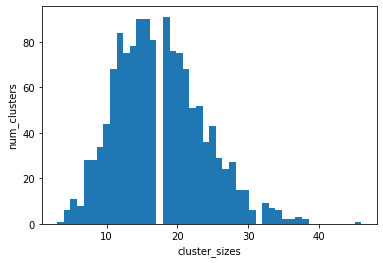

In [38]:
plt.hist(cluster_sizes, 46)
plt.ylabel('num_clusters')
plt.xlabel('cluster_sizes')
plt.show()

In [17]:
leiden_label_df_round_1_arranged = arrange_modules(full_filtered_df, leiden_label_df_round_1, clust_alg, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1.sort_values(by=[f'{clust_alg}_label_{phases}', 'TTHERM_ID'], ascending=False)

Index(['TTHERM_ID', '000min', '030min', '060min', '090min', '120min', '150min',
       '180min'],
      dtype='object')
Index(['TTHERM_ID', '000min', '030min', '060min', '090min', '120min', '150min',
       '180min'],
      dtype='object')
Index(['TTHERM_ID', 'leiden_label_rna_seq'], dtype='object')
          000min    030min    060min    090min    120min    150min    180min
module                                                                      
0      -0.012576  1.559190  1.178600 -0.167043 -1.094590 -1.280810 -0.182772
1      -2.024280  0.107790  1.351588  0.606521  0.200007  0.097429 -0.339056
2       2.091425  0.652772 -0.033135 -0.378930 -0.628726 -0.646577 -1.056830
3      -0.496672 -1.265000 -1.018915 -0.226250  0.542893  1.751200  0.712744
4      -0.705838  1.221493  1.449284  0.496324 -0.330703 -1.088274 -1.042286
...          ...       ...       ...       ...       ...       ...       ...
1361    1.301297  1.131397  0.402669  0.437328 -1.053609 -1.272003 -0.947080
1362  

In [18]:
sscore, modularity

(0.0831550305635297, 0.6445742228289906)

In [19]:
leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)

### LEIDEN CPM

In [20]:
# leiden_label_df_cpms = {}

# la_res_params = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 1]

# print(la_res_params)

# for curr_la_res_param in la_res_params:
#     leiden_label_df_cpm, full_dists_cpm, cpm_sscore, cpm_modularity = build_leiden_label_df(full_filtered_norm_df, 'full', random_state=42, n_neighbors=5, leiden_type='cpm', la_res_param=curr_la_res_param)
#     leiden_label_df_cpm_sorted = leiden_label_df_cpm.sort_values(by='leiden_label_full')
#     print(curr_la_res_param, 'generated', max(list(leiden_label_df_cpm_sorted['leiden_label_full'].values))+1, 'clusters.')
#     leiden_label_df_cpms[curr_la_res_param] = leiden_label_df_cpm_sorted

In [21]:
def leiden_clustering_df_to_csv(df, export_file_path):
    current_module = list(df['leiden_label_full'].values)[0]

    new_cluster = True

    with open(export_file_path, 'w') as f:
        for idx, row in df.iterrows():
            if current_module != row['leiden_label_full']:
                current_module = row['leiden_label_full']
                f.write('\n')
                new_cluster =True

            elif not new_cluster:
                f.write('\t')
            
            f.write(row['TTHERM_ID'])
            new_cluster = False

        f.write('\n')
    
    print(export_file_path, 'successfully exported.')

In [22]:
# leiden_clustering_df_to_csv(leiden_label_df_round_1_sorted, './leiden_clustering.labels')

# for la_param, df in leiden_label_df_cpms.items():
#     leiden_clustering_df_to_csv(df, f'./leiden_clustering_cpm_{str(la_param)}.labels')

In [23]:
# with open('./leiden_clustering.labels', 'r') as f:
#     num_leiden_clusters = f.readlines()
#     print(len(num_leiden_clusters))

# print(max(list(leiden_label_df_round_1_sorted['leiden_label_full'].values)) + 1) # module numbering starts at 0

In [24]:
# rcl_mcl_df.to_csv('./test_nn3_leiden_label_df_round_1_rearranged.csv')

In [25]:
# rcl_mcl_df = pd.read_csv('./mcl_rcl/mcl_rcl_label_df_round_1.csv')
# rcl_mcl_df

In [26]:
# for gene in gene_list_test:
#     print((rcl_mcl_df.loc[rcl_mcl_df['TTHERM_ID'] == gene])['leiden_label_full'].values[0])

In [27]:
# clust_alg = 'leiden'
# phases = 'full'

# arranged_rcl_mcl_df = arrange_modules(full_filtered_norm_df, rcl_mcl_df, clust_alg, phases) 
# sorted_rcl_mcl_df = arranged_rcl_mcl_df.sort_values(by=[f'{clust_alg}_label_{phases}', 'TTHERM_ID'], ascending=False)

In [28]:
# arranged_rcl_mcl_df.loc[arranged_rcl_mcl_df['TTHERM_ID'] == 'TTHERM_00000040']

In [29]:
# sorted_rcl_mcl_df.loc[sorted_rcl_mcl_df['TTHERM_ID'] == 'TTHERM_00000040']

In [30]:
# sorted_rcl_mcl_df.to_csv('./mcl_rcl_label_df_round_1.csv')

In [31]:
# arrange_modules(full_filtered_norm_df, rcl_mcl_df, 'leiden', 'full')['leiden_label_full'].unique()

#### Go to ../enrichment/enrichment.ipynb to generate the functional annotation enrichment data from this clustering. Proceed once done.